# [Going Deeper(CV)_3] CAM을 만들고 평가해 보자

### * 목차
1. 데이터셋 준비하기       
2. CAM 구현       
1) CAM 모델 만들기      
2) CAM 모델 학습하기      
3) CAM 생성      
3. Grad-CAM 구현    
1) Grad_CAM 모델 만들기  
2) Grad-CAM을 이용한 CAM 생성        
4. 바운딩 박스 구하기   
1) Detection with CAM     
2) Detection with Grad-CAM      
5. IoU 구하기(Intersection Over Union)    
6. 결과     

## 1. 데이터셋 준비하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


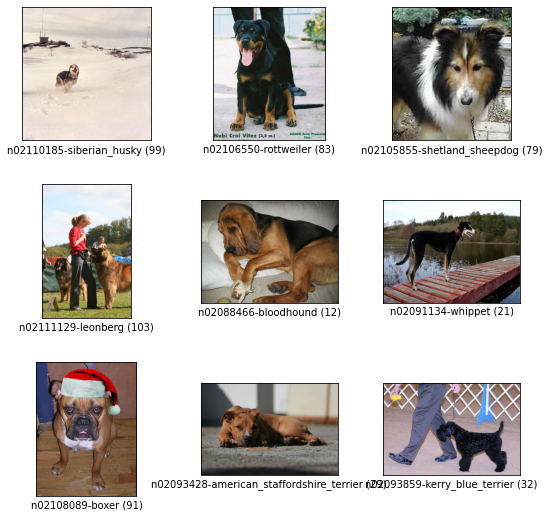

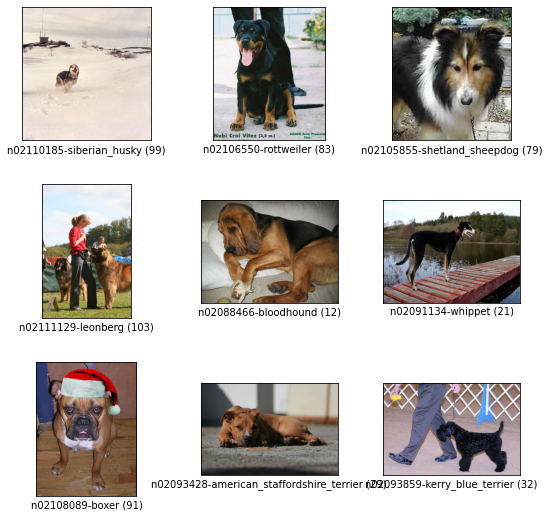

In [4]:
# 각 이미지의 클래스와 그 인덱스(index)를 확인
tfds.show_examples(ds_train, ds_info)

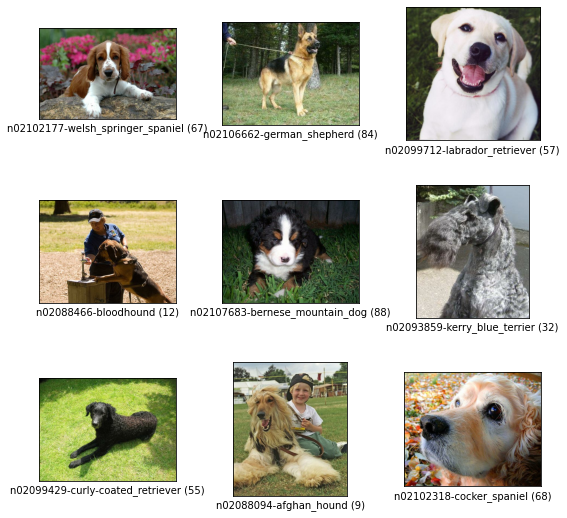

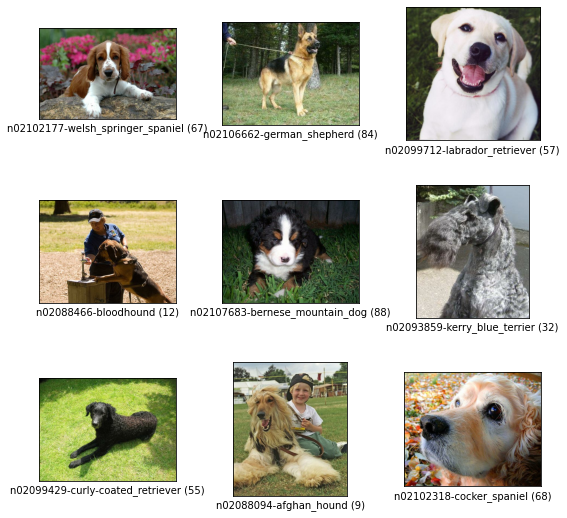

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
# 메타 정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## 2. CAM 구현

### 1) CAM 모델 만들기

In [7]:
# ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94773248/94765736 [==============================] - 1s 0us/step


In [8]:
# CAM모델을 확인
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### 2) CAM 모델 학습하기

In [9]:
# normalizing과 resizing을 포함한 간단한 전처리
    def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

# 배치를 구성
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
# 모델을 컴파일
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
# 모델을 학습
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 394s 475ms/step - loss: 3.1663 - accuracy: 0.2830 - val_loss: 2.8785 - val_accuracy: 0.2736
Epoch 2/20
750/750 [==============================] - 349s 465ms/step - loss: 0.9184 - accuracy: 0.7444 - val_loss: 1.1781 - val_accuracy: 0.6620
Epoch 3/20
750/750 [==============================] - 350s 467ms/step - loss: 0.3489 - accuracy: 0.9134 - val_loss: 1.0028 - val_accuracy: 0.7092
Epoch 4/20
750/750 [==============================] - 350s 467ms/step - loss: 0.1070 - accuracy: 0.9858 - val_loss: 0.9483 - val_accuracy: 0.7238
Epoch 5/20
750/750 [==============================] - 350s 467ms/step - loss: 0.0513 - accuracy: 0.9972 - val_loss: 0.9282 - val_accuracy: 0.7413
Epoch 6/20
750/750 [==============================] - 351s 468ms/step - loss: 0.0211 - accuracy: 0.9990 - val_loss: 0.9240 - val_accuracy: 0.7409
Epoch 7/20
750/750 [==============================] - 351s 468ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9481 -

In [13]:
# 학습시킨 가중치를 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model3.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


### 3) CAM 생성

In [14]:
# 학습한 모델을 활용하여 CAM을 생성
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

71


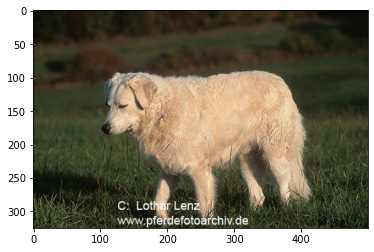

In [148]:
# get_one() 함수로 데이터셋에서 한 장씩 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [149]:
# CAM을 생성하기 위해 이전 스텝에서 학습한 모델을 불러오기
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model3.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [150]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

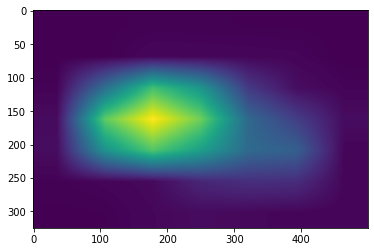

In [151]:
# CAM을 얻기
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [152]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

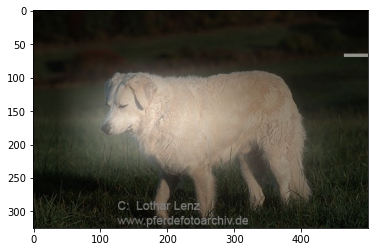

In [153]:
# # CAM 이미지를 원본 이미지와 합치기
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 3. Grad-CAM 구현

### 1) Grad_CAM 모델 만들기

71


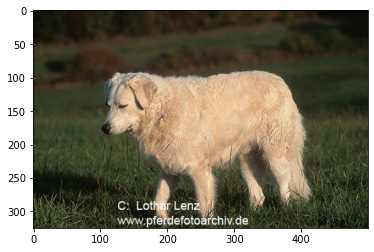

In [189]:
# 우선 새로운 이미지를 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [190]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

### 2) Grad-CAM을 이용한 CAM 생성

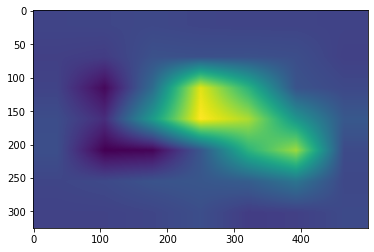

In [191]:
# CAM 이미지 확인
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

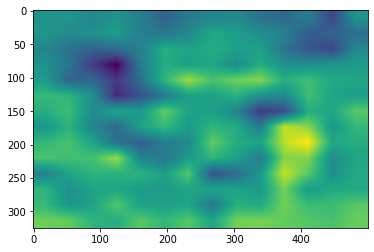

In [192]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

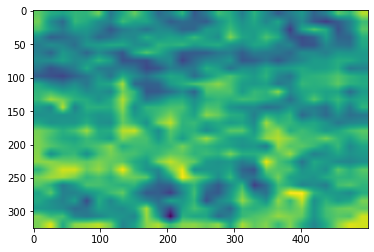

In [193]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## 4. 바운딩 박스 구하기

### 1) Detection with CAM

71


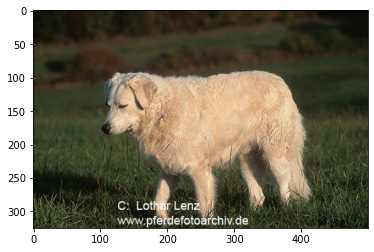

In [167]:
# 우선 새로운 이미지를 다시 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

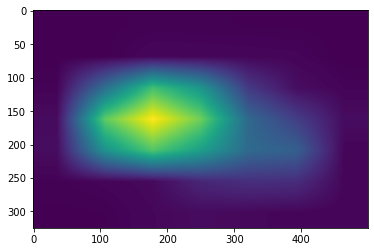

In [168]:
# 그 다음 CAM 이미지를 뽑기
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [169]:
def get_bbox(cam_image, score_thresh=0.05):
    # 1. 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없애기
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    # 2. OpenCV의 findContours()와 minAreaRect()로 사각형을 찾기
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    # 3. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있음
    rotated_rect = cv2.minAreaRect(cnt)
    # 4. boxPoints()로 이를 꼭지점으로 바꾸어 줌
    rect = cv2.boxPoints(rotated_rect)
    # 5. 마지막으로 int 자료형으로 변환
    rect = np.int0(rect)
    return rect

In [170]:
# cam_image를 통해 bbox를 얻기
rect = get_bbox(cam_image)
rect

array([[ 35, 282],
       [ 40,  67],
       [456,  77],
       [451, 291]])

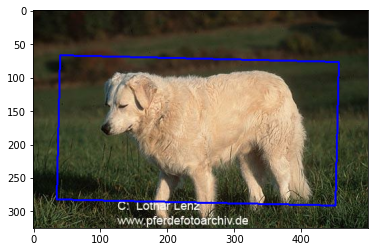

In [171]:
# bbox를 이미지 위에 시각화
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### 2) Detection with Grad-CAM

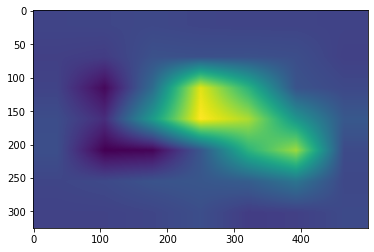

In [194]:
# CAM 이미지 확인
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [195]:
# cam_image를 통해 bbox를 얻기
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[123, 286],
       [129,  62],
       [502,  72],
       [496, 296]])

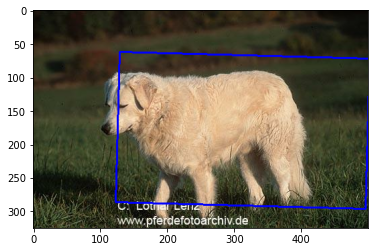

In [196]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

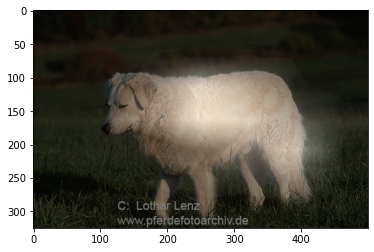

In [203]:
# Grad_CAM 이미지를 원본 이미지와 합치기
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 5. IoU 구하기(Intersection Over Union)
모델이 영역을 잘 찾았는지 비교하는 지표

In [33]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [197]:
# rect를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.20615384615384616, 0.07, 0.8953846153846153, 0.912]

In [198]:
# 데이터의 ground truth bbox를 확인
item['objects']['bbox']

array([[0.27384615, 0.2       , 0.9969231 , 0.836     ]], dtype=float32)

In [199]:
# grad_pred의 ground truth bbox를 확인
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.19076923076923077, 0.246, 0.9107692307692308, 1.004]

In [36]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [200]:
# CAM 추론 결과 bbox와 ground truth bbox가 얼마나 유사한지를 IoU를 계산해서 확인
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6129506637284444

In [201]:
# grad_pred_bbox와 ground truth bbox가 얼마나 유사한지를 IoU를 계산해서 확인
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.596623401805147

## 6. 결과

#### * CAM과 Grad-CAM의 object localization 성능 비교분석

||CAM|Grad_CAM|
|:---:|:---:|:---:|
|map|머리 중심|몸통,꼬리 중심|
|Detection|O|X|
|IoU|0.61|0.59|

         
결과 1) CAM은 머리에 Grad_CAM은 몸통, 꼬리에 중심적으로 활성화가 포커싱 됨.       
결과 2) Grad_CAM는 중심이 꼬리 쪽으로 쏠려, bounding box 가 객체를 조금 벗어났음.       
결과 3) IoU 결과, 객체를 모두 bounding box한 CAM이 조금 더 정답 데이터에 가까운 결과가 나왔음.         